## [Chapter 4](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb)

Notes and exercises from Cam Davidson's *[Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

import daft
import theano.tensor as tt
import pymc3 as pm

np.random.seed(865)

'Done'

/home/alex/.envs/think-series/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'Done'

## Exercises

1) How would estimate the quantity $E[\text{cos} X]$, where $X \sim \text{Exp}(4)$? What about $E[\text{cos} X | X < 1]$, i.e. the expected value *given* we know $X$ is less than 1? Would you need more samples than the original samples size to be equally accurate?

To estimate $E[\text{cos} X]$, I would compute the mean for incrementally larger samples of $X \sim \text{Exp}(4)$. When I do this below, the mean seems to converge around 0.057 with sample size < 1000.

I would compute $E[\text{cos} X | X < 1]$ the same way. I would expect faster convergence because the variance for $X < 1$ is less than that of the unbounded $X$. Recall that the rate of convergence is $\frac{\sqrt{Var(Z)}}{\sqrt{N}}$. The second figure below supports this empirically; the error for estimating $E[\text{cos} X | X < 1]$ is lower about 60% of the time.

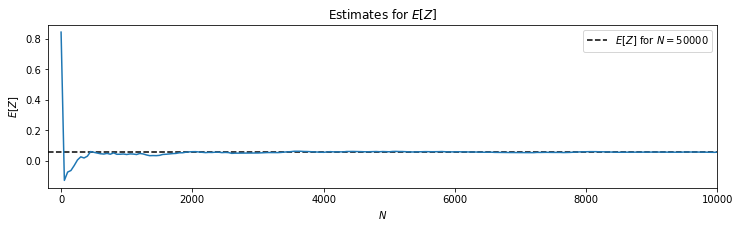

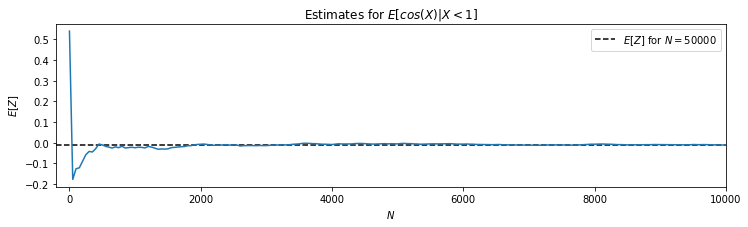

In [70]:
def plot_estimates(Z, xlim, steps=1001, title='Estimates for $E[Z]$'):

    sizes, ests = [], []
    for i in np.linspace(1, len(Z) + 1, steps):
        sizes.append(i)
        ests.append(Z[:int(i)].mean())

    plt.figure(figsize=(12, 3))
    plt.axhline(np.mean(Z), label='$E[Z]$ for $N=%d$' % len(Z), color='k', ls='--')
    plt.plot(sizes, ests)
    plt.xlabel('$N$')
    plt.ylabel('$E[Z]$')
    plt.legend()
    plt.title(title)
    plt.xlim(xlim)
    plt.show()

np.random.seed(865)
exp = stats.expon(scale=4)
N = 5e4
X = exp.rvs(int(N))
Z = np.cos(X)

plot_estimates(Z, xlim=(-200, 10000))

X = np.maximum(X, 1 - 1e-7)
Z = np.cos(X)
plot_estimates(Z, xlim=(-200, 10000), title='Estimates for $E[cos(X) | X < 1]$')

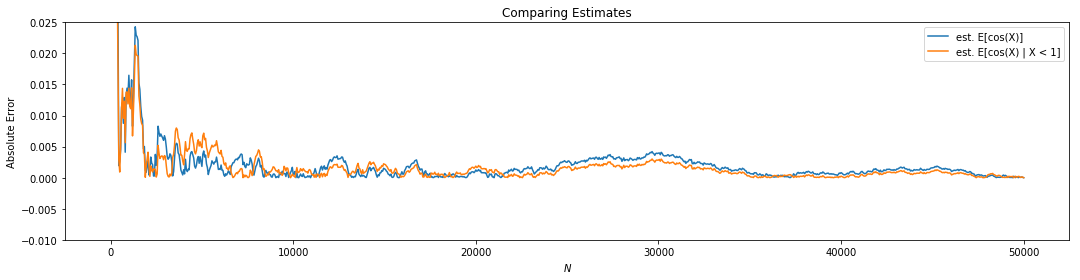

P(D2 < D1) = 0.69730


In [91]:
np.random.seed(865)
exp = stats.expon(scale=4)
N = 5e4
X = exp.rvs(int(N))
Z1 = np.cos(X)
Z2 = np.cos(np.maximum(X, 1 - 1e-7))
E1 = Z1.mean()
E2 = Z2.mean()

D1, D2 = [], []

for i in map(int, np.linspace(1, len(X), 1001)):
    D1.append(abs(Z1[:i].mean() - E1))
    D2.append(abs(Z2[:i].mean() - E2))
    
plt.figure(figsize=(18, 4))
plt.plot(np.linspace(1, len(X), 1001), D1, label='est. E[cos(X)]')
plt.plot(np.linspace(1, len(X), 1001), D2, label='est. E[cos(X) | X < 1]')
plt.title('Comparing Estimates')
plt.ylabel('Absolute Error')
plt.xlabel('$N$')
plt.ylim(-0.01, 0.025)
plt.legend()
plt.show()

print('P(D2 < D1) = %.5lf' % (sum(np.array(D2) < np.array(D1)) / len(D1)))

2a) The following table was located in the paper "Going for Three: Predicting the Likelihood of Field Goal Success with Logistic Regression". The table ranks football field-goal kickers by their percent of non-misses. What mistake have the researchers made?

The kickers are naiively ranked by their accuracy, not accounting for the number of kicks (sample size). Kickers with a smaller sample size have a less certain estimate than those with more kicks. Ignoring this can cause misleading results. For example, the top kicker has accuracy 87.7 with only 57 kicks, compared to the second ranked with accuracy 86.8 and 335 kicks. The difference in accuracy is arguably negligible when considering the second kicker has ~6x more kicks. This is akin to ranking a baseball player with 1 hit and 1 at-bat ahead of the all-time leader, who has a batting average ~0.44.

2b) In August 2013, a popular post on the average income per programmer of different languages was trending. Here's the summary chart. What do you notice about the extremes.

The extreme highs and extreme lows have significantly fewer data points than those in the middle. Again, this is a consequence of greater uncertaintly for small samples.
